In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymaster as nmt
#import seaborn as sns
#import pandas as pd

In [3]:
import numpy as np
from pathlib import Path
import healpy as hp

In [4]:
import os, sys

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import cosmoplotian
import cosmoplotian.colormaps
import matplotlib as mpl
string_cmap = "div yel grn"
#string_cmap = "RdYlBu"
cmap = mpl.cm.get_cmap(string_cmap)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[cmap(0.2), "k", "red"]) 
plt.rcParams['text.usetex'] = False
from matplotlib import patheffects
from matplotlib import text
def outline_text(ax):
    """Add a white outline to all text to make it stand out from the
    background.
    """
    effects = [patheffects.withStroke(linewidth=2, foreground='w')]
    for artist in ax.findobj(text.Text):
        artist.set_path_effects(effects)

# Setup

## Hyperparameters

Architecture hyperparameters:

In [5]:
LAT_DIM = 256
GEN_KERNELS = [4, 4, 4, 4]
INF_KERNELS = [4, 4, 4]

Training hyperparameters:

In [6]:
BETA_1 = 0.5
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 10

In [7]:
PLOT_DIR = Path(os.path.expandvars("$HOME")) / 'vae-paper' / 'figures'
PLOT_DIR.mkdir(exist_ok=True, parents=True)

Setup checkpointing:

In [8]:
CHKPT_NAME = "default"

## Setup default I/O directory to scratch

In [9]:
DIR = Path(os.path.expandvars("$SCRATCH")) / "dustvaeder"
%ls $DIR

I_GNILC_DATASET.cdf               semantic_sequence_dataset.npy
checkpoint                        test_predicted.npy
data_imputation_dataset.npy       test_true.npy
datasets/                         tflogs/
models/                           train_predicted.npy
novel_samples.npy                 train_true.npy
plots/                            trained_vae.data-00000-of-00002
predicted_test.npy                trained_vae.data-00001-of-00002
reconstructed_w_res_dataset.npy   trained_vae.index
results/                          training_dataset.npy
semantic_interpolation_block.npy  true_test.npy


## Read train and test data sets

In [10]:
# size of patch in the x and y dimensions in radians
Lx = 8 * np.pi / 180.
Ly = 8 * np.pi / 180.

In [11]:
# number of pixels in x and y directions
Nx = 256
Ny = 256

In [12]:
# create a mask 
mask = np.ones((256, 256)).flatten()

xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

f = 200.

mask[np.where(xarr.flatten() < Lx / f)] = 0
mask[np.where(xarr.flatten() > (f - 1) * Lx / f)] = 0
mask[np.where(yarr.flatten() < Ly / f)] = 0
mask[np.where(yarr.flatten() > (f - 1) * Ly / f)] = 0
mask = mask.reshape([Ny, Nx])

In [13]:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=1., apotype="C1")


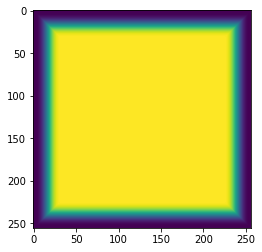

In [14]:
plt.imshow(mask)

In [15]:
cl = np.ones(5000)

In [16]:
field = nmt.synfast_flat(Nx, Ny, Lx, Ly, [cl], [0])

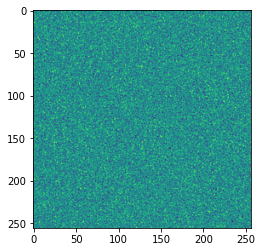

In [17]:
plt.imshow(field[0])

In [18]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, field)

In [19]:
l0_bins = np.arange(Nx/4) * 4 * np.pi/Lx
lf_bins = (np.arange(Nx/4)+1) * 4 * np.pi/Lx

b = nmt.NmtBinFlat(l0_bins, lf_bins)

In [20]:
ells_uncoupled = b.get_effective_ells()
print(ells_uncoupled)

[  45.  135.  225.  315.  405.  495.  585.  675.  765.  855.  945. 1035.
 1125. 1215. 1305. 1395. 1485. 1575. 1665. 1755. 1845. 1935. 2025. 2115.
 2205. 2295. 2385. 2475. 2565. 2655. 2745. 2835. 2925. 3015. 3105. 3195.
 3285. 3375. 3465. 3555. 3645. 3735. 3825. 3915. 4005. 4095. 4185. 4275.
 4365. 4455. 4545. 4635. 4725. 4815. 4905. 4995. 5085. 5175. 5265. 5355.
 5445. 5535. 5625. 5715.]


In [21]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [22]:
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)

(0.0, 500.0)

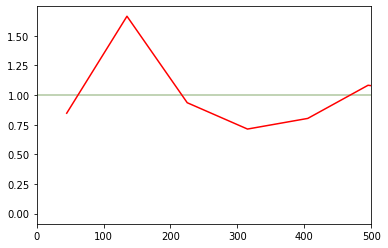

In [23]:
plt.figure()
plt.plot(np.arange(len(cl)), cl)
plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r-', label='Input TT')
plt.xlim(0, 500)

In [24]:
Nsims = 100
cl_simulated = np.zeros((Nsims, b.get_n_bands()))
for i in range(Nsims):
    f0 = nmt.NmtFieldFlat(Lx, Ly, mask, nmt.synfast_flat(Nx, Ny, Lx, Ly, [cl], [0]))
    cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
    cl00_uncoupled = w00.decouple_cell(cl00_coupled)
    cl_simulated[i] = cl00_uncoupled

In [25]:
cov = np.cov(cl_simulated.T)
cl_mean = np.mean(cl_simulated, axis=0)

<ErrorbarContainer object of 3 artists>

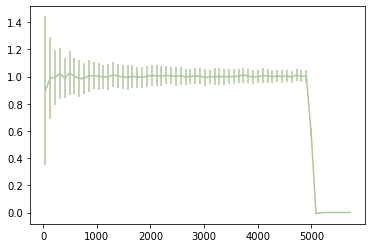

In [26]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(ells_uncoupled, cl_mean, yerr=np.sqrt(np.diag(cov)))

# Power spectra of training data and test data

In [35]:
predicted_train = np.load(DIR / "train_predicted.npy")
predicted_test = np.load(DIR / "test_predicted.npy")

In [36]:
true_train = np.load(DIR / "train_true.npy")
true_test = np.load(DIR / "test_true.npy")

In [37]:
novel_samples = np.load(DIR / "novel_samples.npy")

In [38]:
Ntrain = predicted_train.shape[0]

In [39]:
cl_train = np.zeros((Ntrain, b.get_n_bands()))
for i in range(Ntrain):
    f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [predicted_train[i, :, :, 0]])
    cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
    cl00_uncoupled = w00.decouple_cell(cl00_coupled)
    cl_train[i] = cl00_uncoupled

In [40]:
def get_tt_spectra(dataset, Lx, Ly, mask, binning):
    """ Get tt spectra of images (assumed shape (nsamples, xdim, ydim, nchannels))
    """
    N = dataset.shape[0]
    cl = np.zeros((N, binning.get_n_bands()))
    for i in range(N):
        f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [dataset[i, :, :, 0]])
        cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
        cl00_uncoupled = w00.decouple_cell(cl00_coupled)
        cl[i] = cl00_uncoupled
    return cl

cl_predicted_train = get_tt_spectra(predicted_train, Lx, Ly, mask, b)
cl_true_train = get_tt_spectra(true_train, Lx, Ly, mask, b)

cl_predicted_test = get_tt_spectra(predicted_test, Lx, Ly, mask, b)
cl_true_test = get_tt_spectra(true_test, Lx, Ly, mask, b)

In [41]:
def get_tt_cross(dataset_a, dataset_b, Lx, Ly, mask, binning):
    """ Get tt spectra of images (assumed shape (nsamples, xdim, ydim, nchannels))
    """
    N = dataset_a.shape[0]
    cl = np.zeros((N, binning.get_n_bands()))
    for i in range(N):
        f0_a = nmt.NmtFieldFlat(Lx, Ly, mask, [dataset_a[i, :, :, 0]])
        f0_b = nmt.NmtFieldFlat(Lx, Ly, mask, [dataset_b[i, :, :, 0]])
        cl00_coupled = nmt.compute_coupled_cell_flat(f0_a, f0_b, b)
        cl00_uncoupled = w00.decouple_cell(cl00_coupled)
        cl[i] = cl00_uncoupled
    return cl

In [42]:
cl_test_residuals = get_tt_cross(predicted_test - true_test, true_test, Lx, Ly, mask, b)

In [63]:
cl_novel = get_tt_spectra(novel_samples, Lx, Ly, mask, b)

In [44]:
cl_test_residuals_mean = np.mean(cl_test_residuals, axis=0)
cl_test_residuals_cov = np.cov(cl_test_residuals.T)

In [45]:
cl_predicted_train_mean = np.mean(cl_predicted_train, axis=0)
cl_predicted_train_cov = np.cov(cl_predicted_train.T)

cl_true_train_mean = np.mean(cl_true_train, axis=0)
cl_true_train_cov = np.cov(cl_true_train.T)

cl_predicted_test_mean = np.mean(cl_predicted_test, axis=0)
cl_predicted_test_cov = np.cov(cl_predicted_test.T)

cl_true_test_mean = np.mean(cl_true_test, axis=0)
cl_true_test_cov = np.cov(cl_true_test.T)

In [46]:
print(any(cl_predicted_train_mean < 0))
print(any(cl_true_train_mean < 0))
print(any(cl_predicted_test_mean < 0))
print(any(cl_true_test_mean < 0))

print(any(np.diag(cl_predicted_train_cov) < 0))
print(any(np.diag(cl_true_train_cov) < 0))
print(any(np.diag(cl_predicted_test_cov) < 0))
print(any(np.diag(cl_true_test_cov) < 0))

False
False
False
False
False
False
False
False


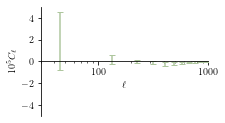

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.errorbar(ells_uncoupled, 1e5*cl_test_residuals_mean, yerr=1e5*np.sqrt(np.diag(cl_test_residuals_cov)), capsize=3., linestyle="none")

#ax.axhline(y=0, color='gray')
#custom_lines = [Line2D([0], [0], color="C0", lw=4),
#                Line2D([0], [0], color="C1", lw=4)]
#ax.legend(custom_lines, (r"$\tilde x$", r"$x$"), frameon=False)
ax.set_xlim(30, 1000)
ax.set_ylim(-5, 5)
ax.set_yscale('linear')
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$10^5 C_\ell$")
ax.set_xscale("log")
ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels([r"$100$", r"$1000$"])
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig("residuals_spectra.pdf", bbox_inches="tight")

In [48]:
res_quantiles = np.nanquantile(cl_true_test - cl_test_residuals, [0.25, 0.5, 0.75], axis=0)

[Text(100, 0, '100'), Text(1000, 0, '1000')]

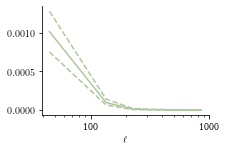

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(ells_uncoupled[:10], res_quantiles[0][:10], 'C0--')
ax.plot(ells_uncoupled[:10], res_quantiles[1][:10], 'C0-')
ax.plot(ells_uncoupled[:10], res_quantiles[2][:10], 'C0--')

#custom_lines = [Line2D([0], [0], color="C0", lw=4),
#                Line2D([0], [0], color="C1", lw=4)]
#ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.set_xscale('log')

#ax.set_ylim(0,1.)
ax.set_xlabel(r"$\ell$")
#ax.set_ylabel(r"$\log(C_\ell)$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
#fig.savefig("spectra_distribution_quantiles.pdf", bbox_inches="tight")

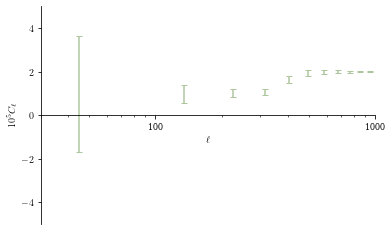

In [50]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(ells_uncoupled, 1-cl_test_residuals_mean / cl_true_test_mean, yerr=1e5 * np.sqrt(np.diag(cl_test_residuals_cov)), capsize=3., linestyle="none")

#ax.axhline(y=0, color='gray')
#custom_lines = [Line2D([0], [0], color="C0", lw=4),
#                Line2D([0], [0], color="C1", lw=4)]
#ax.legend(custom_lines, (r"$\tilde x$", r"$x$"), frameon=False)
ax.set_xlim(30, 1000)
ax.set_ylim(-5, 5)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$10^5C_\ell$")
ax.set_xscale("log")
ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

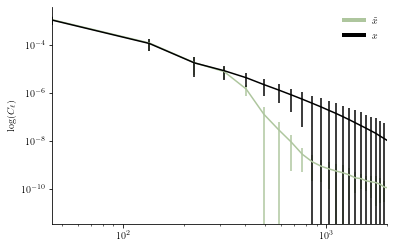

In [51]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(ells_uncoupled, cl_predicted_test_mean, yerr=np.sqrt(np.diag(cl_predicted_test_cov)))
ax.errorbar(ells_uncoupled, cl_true_test_mean, yerr=np.sqrt(np.diag(cl_true_test_cov)))

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"$\tilde x$", r"$x$"), frameon=False)
ax.set_xlim(b.get_effective_ells()[0], 2000)

ax.set_xlabel
(r"$\ell$")
ax.set_ylabel(r"$\log(C_\ell)$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

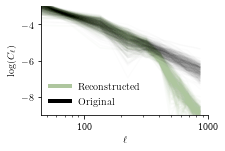

In [52]:
plt.rcParams["text.usetex"] = True

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

for i in range(cl_predicted_test.shape[0]):
    if any(cl_predicted_test[i, :10] < 0): 
        pass
    else:
        ax.plot(ells_uncoupled[:10], np.log10(cl_predicted_test[i][:10]), color='C0', alpha=0.05)
for i in range(cl_predicted_test.shape[0]):
    if any(cl_true_test[i, :10] < 0): 
        pass
    else:
        ax.plot(ells_uncoupled[:10], np.log10(cl_true_test[i][:10]), color='C1', alpha=0.01)

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False)
ax.set_xlim(b.get_effective_ells()[0], 1000)
ax.set_ylim(-9, -3)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log(C_\ell)$")
ax.set_xscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("powerspectrum_distribution.pdf", bbox_inches="tight")

In [61]:
true_test_quantiles = np.nanquantile(np.log10(cl_predicted_test), [0.25, 0.5, 0.75], axis=0)
pred_test_quantiles = np.nanquantile(np.log10(cl_true_test), [0.25, 0.5, 0.75], axis=0)

<ipython-input-61-33c28c5d71d6>:1: RuntimeWarning: invalid value encountered in log10
  true_test_quantiles = np.nanquantile(np.log10(cl_predicted_test), [0.25, 0.5, 0.75], axis=0)
<ipython-input-61-33c28c5d71d6>:2: RuntimeWarning: invalid value encountered in log10
  pred_test_quantiles = np.nanquantile(np.log10(cl_true_test), [0.25, 0.5, 0.75], axis=0)


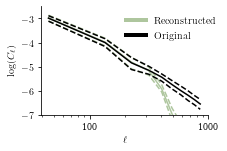

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(ells_uncoupled[:10], true_test_quantiles[0][:10], 'C0--')
ax.plot(ells_uncoupled[:10], true_test_quantiles[1][:10], 'C0-')
ax.plot(ells_uncoupled[:10], true_test_quantiles[2][:10], 'C0--')

ax.plot(ells_uncoupled[:10], pred_test_quantiles[0][:10], 'C1--')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[1][:10], 'C1-')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[2][:10], 'C1--')

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.set_xscale('log')

ax.set_ylim(-7, -2.5)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log(C_\ell)$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("spectra_distribution_quantiles.pdf", bbox_inches="tight")

In [66]:
true_test_quantiles = np.nanquantile(cl_predicted_test, [0.25, 0.5, 0.75], axis=0)
cl_novel_quantiles = np.nanquantile(cl_novel, [0.25, 0.5, 0.75], axis=0)

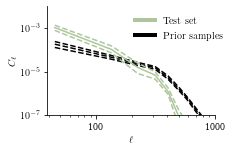

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(ells_uncoupled[:10], cl_novel_quantiles[0][:10], 'C1--')
ax.plot(ells_uncoupled[:10], cl_novel_quantiles[1][:10], 'C1--')
ax.plot(ells_uncoupled[:10], cl_novel_quantiles[2][:10], 'C1--')

ax.plot(ells_uncoupled[:10], true_test_quantiles[0][:10], 'C0--')
ax.plot(ells_uncoupled[:10], true_test_quantiles[1][:10], 'C0-')
ax.plot(ells_uncoupled[:10], true_test_quantiles[2][:10], 'C0--')


custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Test~set}$", r"${\rm Prior~samples}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-7, 1e-2)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$C_\ell$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("novel_spectra_distribution_quantiles.pdf", bbox_inches="tight")



In [107]:
true_test_quantiles = np.nanquantile(cl_predicted_test, [0.25, 0.5, 0.75], axis=0)
pred_test_quantiles = np.nanquantile(cl_true_test, [0.25, 0.5, 0.75], axis=0)

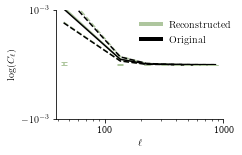

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(ells_uncoupled[:10], true_test_quantiles[0][:10], 'C0--')
ax.plot(ells_uncoupled[:10], true_test_quantiles[1][:10], 'C0-')
ax.plot(ells_uncoupled[:10], true_test_quantiles[2][:10], 'C0--')

ax.plot(ells_uncoupled[:10], pred_test_quantiles[0][:10], 'C1--')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[1][:10], 'C1-')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[2][:10], 'C1--')

ax.errorbar(ells_uncoupled[:10], cl_test_residuals_mean[:10], yerr=np.sqrt(np.diag(cl_test_residuals_cov[:10])), capsize=3., linestyle="none")

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.set_xscale('log')
ax.set_yscale('symlog')
ax.set_ylim(-1e-3, 1e-3)
#ax.set_ylim(-9, -3)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log(C_\ell)$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("spectra_distribution_quantiles.pdf", bbox_inches="tight")



In [69]:
true_test_quantiles = np.nanquantile(1e5*cl_predicted_test, [0.25, 0.5, 0.75], axis=0)
pred_test_quantiles = np.nanquantile(1e5*cl_true_test, [0.25, 0.5, 0.75], axis=0)

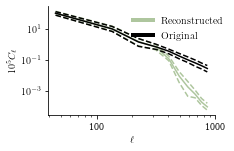

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(ells_uncoupled[:10], true_test_quantiles[0][:10], 'C0--')
ax.plot(ells_uncoupled[:10], true_test_quantiles[1][:10], 'C0-')
ax.plot(ells_uncoupled[:10], true_test_quantiles[2][:10], 'C0--')

ax.plot(ells_uncoupled[:10], pred_test_quantiles[0][:10], 'C1--')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[1][:10], 'C1-')
ax.plot(ells_uncoupled[:10], pred_test_quantiles[2][:10], 'C1--')

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(-9, -3)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$10^5 C_\ell$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("spectra_distribution_quantiles.pdf", bbox_inches="tight")

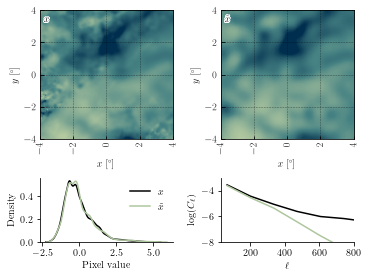

In [74]:
i = 1

height_ratios = [2, 1]
width_ratios = [2, 2]

fig = plt.figure(constrained_layout=True, figsize=(4 * 1.25, 3 * 1.25))

spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=width_ratios, height_ratios=height_ratios)


ax1 = fig.add_subplot(spec[0, 0])
ax1.imshow(true_test[i, :, :, 0])

kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': string_cmap,
        'vmin': -3,
        'vmax': 3
    }

ax1.imshow(true_test[i, :, :, 0], **kwds)
ax1.annotate(r"$x$", xy=(0.03, 0.91), xycoords='axes fraction')
outline_text(ax1)


ax2 = fig.add_subplot(spec[0, 1])
ax2.imshow(predicted_test[i, :, :, 0], **kwds)

for ax in [ax1, ax2]:
    ax.set_ylabel(r"$y~{\rm [^\circ]}$")
    ax.set_xlabel(r"$x~{\rm [^\circ]}$")
    ax.xaxis.set_ticks([-4, -2, 0, 2, 4])
    ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
    ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
    ax.tick_params(axis='both', direction='in')
    ax.tick_params(axis='x', rotation=90)
    outline_text(ax)

ax2.annotate(r"$\tilde x$", xy=(0.03, 0.91), xycoords='axes fraction')
outline_text(ax2)
    
ax3 = fig.add_subplot(spec[1, 0])
sns.kdeplot(data=true_test[i, :, :, 0].flatten(), ax=ax3, color="C1", label=r"$x$")
sns.kdeplot(data=predicted_test[i, :, :, 0].flatten(), ax=ax3, color="C0", label=r"$\tilde x$")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.legend(frameon=False)

ax3.set_xlabel(r"${\rm Pixel~value}$")
ax3.set_ylabel(r"${\rm Density}$")

ax4 = fig.add_subplot(spec[1, 1])
ax4.plot(ells_uncoupled[:10], np.log10(cl_true_test[3][:10]), color="C1", label=r"$x$")
ax4.plot(ells_uncoupled[:10], np.log10(cl_predicted_test[3][:10]), color="C0", label=r"$\tilde x$")
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)


ax4.set_xlabel(r"$\ell$")
ax4.set_ylabel(r"$\log(C_\ell)$")
ax4.set_xlim(30, 800)
ax4.set_ylim(-8, -3)

fig.savefig("panelplot.pdf")

In [75]:
print(cl_true_test.shape)

(336, 43)


In [76]:
print(cl_true_train.shape)

(1576, 43)


In [77]:
true_test_quantiles = np.quantile(true_test.reshape((-1, 256 * 256)), [0.25, 0.5, 0.75], axis=0)

In [78]:
nbins = 50
hist_range = [-3, 5]
true_test_histo = np.zeros((true_test.shape[0], nbins))
for i in range(true_test.shape[0]):
    hist, edges = np.histogram(true_test[i], range=hist_range, bins=nbins, density=True)
    true_test_histo[i] = hist
    
pred_test_histo = np.zeros((predicted_test.shape[0], nbins))
for i in range(predicted_test.shape[0]):
    hist, edges = np.histogram(predicted_test[i], range=hist_range, bins=nbins, density=True)
    pred_test_histo[i] = hist

In [87]:
true_test_quantiles = np.quantile(true_test_histo, [0.25, 0.5, 0.75], axis=0)
pred_test_quantiles = np.quantile(pred_test_histo, [0.25, 0.5, 0.75], axis=0)

In [88]:
np.linspace(hist_range[0], hist_range[1], 51)

array([-3.  , -2.84, -2.68, -2.52, -2.36, -2.2 , -2.04, -1.88, -1.72,
       -1.56, -1.4 , -1.24, -1.08, -0.92, -0.76, -0.6 , -0.44, -0.28,
       -0.12,  0.04,  0.2 ,  0.36,  0.52,  0.68,  0.84,  1.  ,  1.16,
        1.32,  1.48,  1.64,  1.8 ,  1.96,  2.12,  2.28,  2.44,  2.6 ,
        2.76,  2.92,  3.08,  3.24,  3.4 ,  3.56,  3.72,  3.88,  4.04,
        4.2 ,  4.36,  4.52,  4.68,  4.84,  5.  ])

In [89]:
bin_centers = (edges + (edges[1] - edges[0]) / 2)[:-1]
print(bin_centers.shape)
print(bin_centers)

(50,)
[-2.92       -2.7599998  -2.6        -2.44       -2.2799997  -2.12
 -1.9599999  -1.8        -1.64       -1.4799999  -1.3199999  -1.16
 -1.         -0.84       -0.67999995 -0.52       -0.35999995 -0.19999996
 -0.03999995  0.12000004  0.28000003  0.44000006  0.6         0.76000005
  0.92        1.08        1.24        1.4000001   1.5600001   1.72
  1.88        2.04        2.1999998   2.3600001   2.52        2.6799998
  2.8400002   3.          3.1599998   3.3200002   3.48        3.6399999
  3.8000002   3.96        4.12        4.2799997   4.44        4.6
  4.7599998   4.92      ]


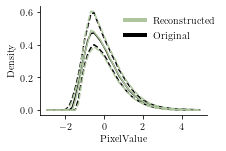

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(bin_centers, true_test_quantiles[0], 'C1--')
ax.plot(bin_centers, true_test_quantiles[1], 'C1-')
ax.plot(bin_centers, true_test_quantiles[2], 'C1--')

ax.plot(bin_centers, pred_test_quantiles[0], 'C0--')
ax.plot(bin_centers, pred_test_quantiles[1], 'C0-')
ax.plot(bin_centers, pred_test_quantiles[2], 'C0--')

ax.set_xlabel(r"${\rm Pixel Value}$")
ax.set_ylabel(r"${\rm Density}$")

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Reconstructed}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("histogram_distribution.pdf", bbox_inches="tight")

In [91]:
true_test_quantiles.shape

(3, 50)

In [ ]:
fig, ax = plt.subplots(4, 4)
for i in range(16):
    ax.flatten()[i].imshow(novel_samples[i, :, :, 0])

In [ ]:
nbins = 50
hist_range = [-3, 5]
novel_histo = np.zeros((novel_samples.shape[0], nbins))
for i in range(true_test.shape[0]):
    hist, edges = np.histogram(novel_samples[i], range=hist_range, bins=nbins, density=True)
    novel_histo[i] = hist

In [ ]:
novel_quantiles = np.quantile(novel_histo, [0.25, 0.5, 0.75], axis=0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(bin_centers, true_test_quantiles[0], 'C1--')
ax.plot(bin_centers, true_test_quantiles[1], 'C1-')
ax.plot(bin_centers, true_test_quantiles[2], 'C1--')

ax.plot(bin_centers, novel_quantiles[0], 'C0--')
ax.plot(bin_centers, novel_quantiles[1], 'C0-')
ax.plot(bin_centers, novel_quantiles[2], 'C0--')

ax.set_xlabel(r"${\rm Pixel Value}$")
ax.set_ylabel(r"${\rm Density}$")

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Novel}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("histogram_novel_distribution.pdf", bbox_inches="tight")

# Data Imputation Spectra

In [189]:
data_imputation_dataset = np.load(DIR / "data_imputation_dataset.npy")

In [200]:
nbins = 50
hist_range = [-3, 5]
imputation_histo = np.zeros((data_imputation_dataset.shape[0], nbins))
for i in range(data_imputation_dataset.shape[0]):
    hist, edges = np.histogram(data_imputation_dataset[i], range=hist_range, bins=nbins, density=True)
    imputation_histo[i] = hist

In [191]:
imputation_cls = get_tt_spectra(data_imputation_dataset, Lx, Ly, mask, b)

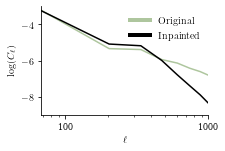

In [199]:
plt.rcParams["text.usetex"] = True

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

#ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[0][:10]), color='C0')
#ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[6][:10]), color='C1')

ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[1][:10]), color='C0')
ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[7][:10]), color='C1')

#ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[2][:10]), color='C0')
#ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[8][:10]), color='C1')



custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]

ax.legend(custom_lines, (r"${\rm Original}$", r"${\rm Inpainted}$"), frameon=False)
ax.set_xlim(b.get_effective_ells()[0], 1000)
ax.set_ylim(-9, -3)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log(C_\ell)$")
ax.set_xscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks([100, 1000])
ax.xaxis.set_ticklabels(["100", "1000"])
fig.savefig("data_imputation.pdf", bbox_inches="tight")

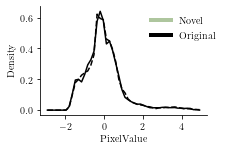

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(bin_centers, imputation_histo[2], 'C1--')
ax.plot(bin_centers, imputation_histo[8], 'C1-')

#ax.plot(bin_centers, novel_quantiles[0], 'C0--')
#ax.plot(bin_centers, novel_quantiles[1], 'C0-')
#ax.plot(bin_centers, novel_quantiles[2], 'C0--')

ax.set_xlabel(r"${\rm Pixel Value}$")
ax.set_ylabel(r"${\rm Density}$")

custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4)]
ax.legend(custom_lines, (r"${\rm Novel}$", r"${\rm Original}$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("histogram_imputation.pdf", bbox_inches="tight")

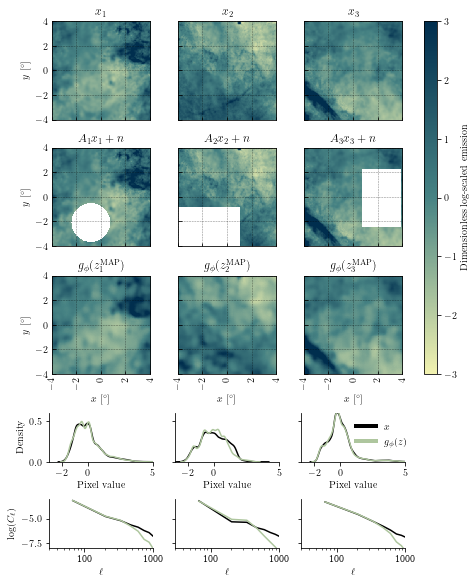

In [255]:
i = 1

height_ratios = [2, 2, 2, 1, 1]
width_ratios = [2, 2, 2, 0.25]

fig = plt.figure(constrained_layout=True, figsize=(6.5, 8))

spec = fig.add_gridspec(ncols=4, nrows=5, width_ratios=width_ratios, height_ratios=height_ratios)


kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': string_cmap,
        'vmin': -3,
        'vmax': 3
    }

titles = [
        r"$x_1$",
        r"$x_2$",
        r"$x_3$",
        r"$A_1 x_1 + n$",
        r"$A_2 x_2 + n$",
        r"$A_3 x_3 + n$",
        r"$g_\phi(z_1^{\rm MAP})$",
        r"$g_\phi(z_2^{\rm MAP})$",
        r"$g_\phi(z_3^{\rm MAP})$",
]

k = 0
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(spec[i, j]) 
        ax.xaxis.set_ticks([-4, -2, 0, 2, 4])
        ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
        if i == 2:
            ax.set_xlabel(r"$x~{\rm [^\circ]}$")
        else:
            ax.xaxis.set_ticklabels([])
        if j == 0:
            ax.set_ylabel(r"$y~{\rm [^\circ]}$")
        else:
            ax.yaxis.set_ticklabels([])
        img = ax.imshow(data_imputation_dataset[k, :, :, 0], **kwds)
        ax.set_title(titles[k])
        k += 1
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        ax.set_box_aspect(1) 
    
cbax = fig.add_subplot(spec[0:3, -1])
cbar = fig.colorbar(img, cax=cbax)

cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cbar.set_label(r"{\rm Dimensionless log-scaled emission}")

for i in range(3):
    ax = fig.add_subplot(spec[3, i])
    sns.kdeplot(data=data_imputation_dataset[i, :, :, 0].flatten(), ax=ax, color="C1")
    sns.kdeplot(data=data_imputation_dataset[i+6, :, :, 0].flatten(), ax=ax, color="C0")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(-3, 5)
    ax.set_xticks([-2, 0, 5])
    
    ax.set_xlabel(r"${\rm Pixel~value}$")
    ax.set_ylim(0., 0.6)
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel(r"${\rm Density}$")
    if i != 0:
        ax.yaxis.set_ticklabels([])
        
    if i == 2:
        custom_lines = [Line2D([0], [0], color="C1", lw=4),
                        Line2D([0], [0], color="C0", lw=4)]
        ax.legend(custom_lines, (r"$x$", r"$g_\phi(z)$"), frameon=False, loc="upper right", bbox_to_anchor=(1.1, 1.))

for i in range(3):
    ax = fig.add_subplot(spec[4, i])
    ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[i][:10]), color="C1")
    ax.plot(ells_uncoupled[:10], np.log10(imputation_cls[i+6][:10]), color="C0")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xscale('log')
    ax.xaxis.set_ticks([100, 1000])
    ax.xaxis.set_ticklabels(["100", "1000"])
    ax.set_xlabel(r"$\ell$")
    if i == 0:
        ax.set_ylabel(r"$\log(C_\ell)$")
    ax.set_xlim(30, 1000)
    ax.set_ylim(-8, -3)
    
    if i != 0:
        ax.yaxis.set_ticklabels([])

fig.savefig("data_imputation_panel_plot.pdf", bbox_inches="tight")

In [207]:
    
ax2.annotate(r"$\tilde x$", xy=(0.03, 0.91), xycoords='axes fraction')
outline_text(ax2)
    
ax3 = fig.add_subplot(spec[1, 0])
sns.kdeplot(data=true_test[i, :, :, 0].flatten(), ax=ax3, color="C1", label=r"$x$")
sns.kdeplot(data=predicted_test[i, :, :, 0].flatten(), ax=ax3, color="C0", label=r"$\tilde x$")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.legend(frameon=False)

ax3.set_xlabel(r"${\rm Pixel~value}$")
ax3.set_ylabel(r"${\rm Density}$")

ax4 = fig.add_subplot(spec[1, 1])
ax4.plot(ells_uncoupled[:10], np.log10(cl_true_test[3][:10]), color="C1", label=r"$x$")
ax4.plot(ells_uncoupled[:10], np.log10(cl_predicted_test[3][:10]), color="C0", label=r"$\tilde x$")
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)


ax4.set_xlabel(r"$\ell$")
ax4.set_ylabel(r"$\log(C_\ell)$")
ax4.set_xlim(30, 800)
ax4.set_ylim(-8, -3)

fig.savefig("panelplot.pdf")

IndexError: index 6 is out of bounds for GridSpec with size 4